# DANTE 合金材料设计优化

本笔记本演示如何使用DANTE框架进行合金材料的成分优化，以获取最佳的机械性能（弹性模量和屈服强度的组合）。

## 内容概览

1. **第一部分**：数据加载与预处理
2. **第二部分**：定义DANTE算法组件
3. **第三部分**：构建神经网络代理模型
4. **第四部分**：使用DANTE进行优化
5. **第五部分**：结果可视化与分析

## 第一部分：数据加载与预处理

首先导入必要的库，并加载合金材料数据集。

In [1]:
# 导入必要的库
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 设置可视化样式
plt.style.use('ggplot')
sns.set(style="whitegrid")

# 检查数据文件是否存在
data_path = "data.csv"
if os.path.exists(data_path):
    print(f"数据文件 {data_path} 存在")
else:
    print(f"警告：数据文件 {data_path} 不存在！")
    
    # 如果在上级目录中有数据文件，尝试复制它
    parent_data_path = "../../../data.csv"
    if os.path.exists(parent_data_path):
        print(f"在上级目录中找到数据文件，正在复制到当前目录...")
        import shutil
        shutil.copy(parent_data_path, data_path)
        print("复制完成！")
    else:
        print("在上级目录中也没有找到数据文件，请确保数据文件可用。")

# 如果数据文件存在，加载它
if os.path.exists(data_path):
    df = pd.read_csv(data_path)
    print(f"成功加载数据集，共 {len(df)} 个样本")
    print("\n数据集前5行：")
    display(df.head())
else:
    print("无法加载数据集，请确保数据文件可用。")
    df = None

数据文件 data.csv 存在
成功加载数据集，共 621 个样本

数据集前5行：


,sid,elastic,yield,phase_ratio_dict,ds
0,Co8.50Mo5.15Ti2.60,1.420000e+11,999045917.8,"{""martensite"": 0.6559944215529168, ""Fe2Mo"": 0....",20250304
1,Co8.50Mo5.25Ti2.20,1.190000e+11,850372168.9,"{""martensite"": 0.6366681307104562, ""Fe2Mo"": 0....",20250304
2,Co8.50Mo5.25Ti0.80,8.903661e+10,641555721.0,"{""martensite"": 0.5781999583214714, ""Fe2Mo"": 0....",20250304
3,Co8.50Mo5.45Ti2.60,1.330000e+11,945353657.3,"{""martensite"": 0.6500110673714325, ""Fe2Mo"": 0....",20250304
4,Co8.50Mo4.90Ti1.60,1.070000e+11,780448554.7,"{""martensite"": 0.6179089154319106, ""Fe2Mo"": 0....",20250304


### 数据预处理

现在我们需要提取合金成分信息和目标属性（弹性模量和屈服强度）。


数据处理摘要：
输入维度: (621, 3)
输出维度: (621,)
弹性模量平均值: 1.21e+11
屈服强度平均值: 856914898.26

成分范围：
Co: 8.50 to 11.20
Mo: 4.90 to 5.50
Ti: 0.80 to 3.00


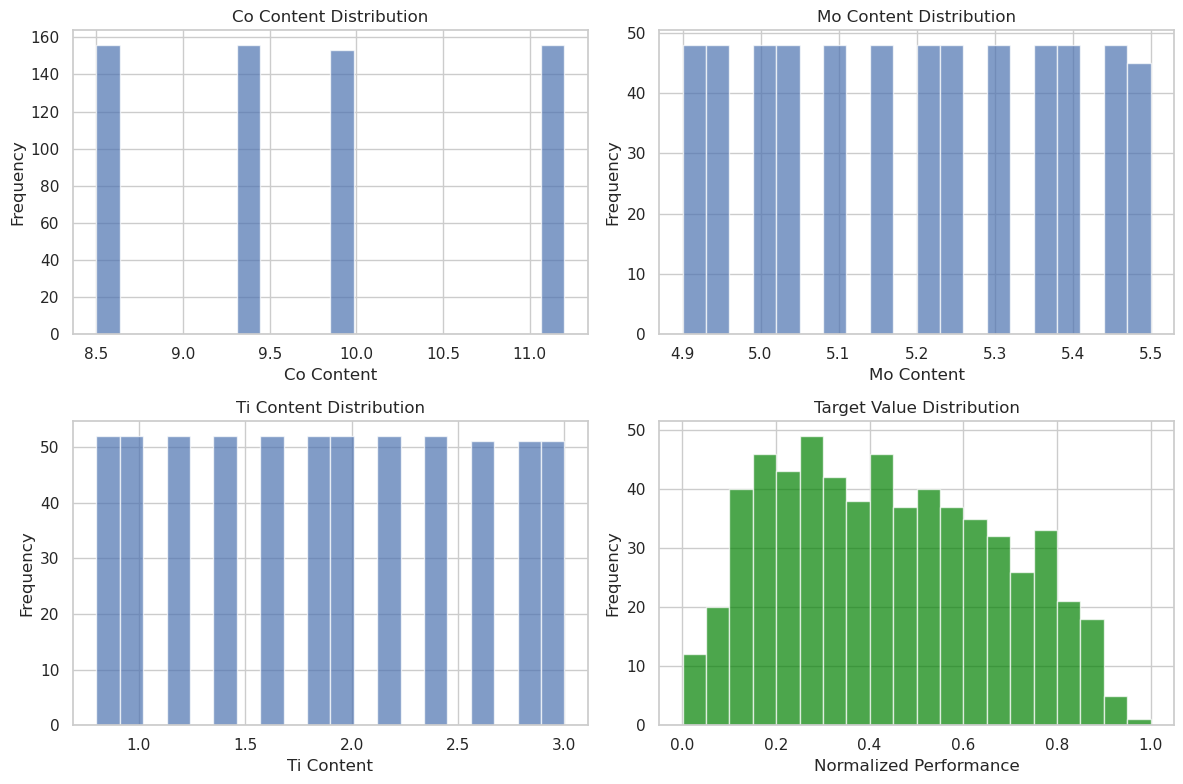

<Figure size 1000x800 with 0 Axes>

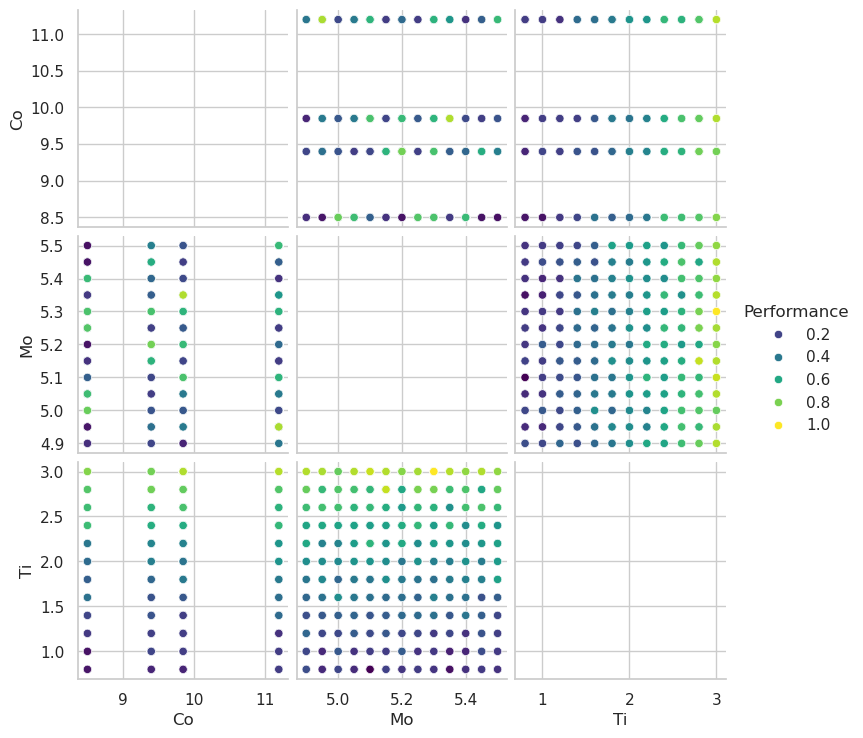

In [2]:
def extract_composition(sid):
    """
    从材料ID中提取元素成分
    
    示例：从 "Co8.50Mo5.15Ti2.60" 提取 [8.50, 5.15, 2.60]
    """
    elements = ['Co', 'Mo', 'Ti']
    values = []
    
    # 提取每个元素的数值
    for element in elements:
        if element in sid:
            # 找到元素在字符串中的位置
            pos = sid.find(element) + len(element)
            # 找到下一个元素的位置或字符串结尾
            next_pos = len(sid)
            for next_elem in elements:
                if next_elem != element and sid.find(next_elem, pos) != -1:
                    next_pos = min(next_pos, sid.find(next_elem, pos))
            # 提取数值
            value = float(sid[pos:next_pos])
            values.append(value)
        else:
            values.append(0.0)
            
    return values


if df is not None:
    # 提取每个数据点的成分值
    composition_values = df['sid'].apply(extract_composition)
    X = np.array(composition_values.tolist())
    
    # 提取目标值（弹性模量和屈服强度）并标准化（归一化到0-1区间）
    elastic_values = df['elastic'].values
    yield_values = df['yield'].values

    elastic_min = np.min(elastic_values)
    elastic_max = np.max(elastic_values)
    yield_min = np.min(yield_values)
    yield_max = np.max(yield_values)

    # 归一化到0-1区间
    elastic_norm = (elastic_values - elastic_min) / (elastic_max - elastic_min)
    yield_norm = (yield_values - yield_min) / (yield_max - yield_min)

    # 计算均值用于后续摘要
    elastic_mean = np.mean(elastic_values)
    yield_mean = np.mean(yield_values)
    
    # 将目标定义为标准化值的平均值
    Y = (elastic_norm + yield_norm) / 2
    
    print("\n数据处理摘要：")
    print(f"输入维度: {X.shape}")
    print(f"输出维度: {Y.shape}")
    print(f"弹性模量平均值: {elastic_mean:.2e}")
    print(f"屈服强度平均值: {yield_mean:.2f}")
    
    # 显示成分范围
    print("\n成分范围：")
    print(f"Co: {X[:, 0].min():.2f} to {X[:, 0].max():.2f}")
    print(f"Mo: {X[:, 1].min():.2f} to {X[:, 1].max():.2f}")
    print(f"Ti: {X[:, 2].min():.2f} to {X[:, 2].max():.2f}")
    
    # 绘制数据分布
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.hist(X[:, 0], bins=20, alpha=0.7)
    plt.title('Co Content Distribution')
    plt.xlabel('Co Content')
    plt.ylabel('Frequency')
    
    plt.subplot(2, 2, 2)
    plt.hist(X[:, 1], bins=20, alpha=0.7)
    plt.title('Mo Content Distribution')
    plt.xlabel('Mo Content')
    plt.ylabel('Frequency')
    
    plt.subplot(2, 2, 3)
    plt.hist(X[:, 2], bins=20, alpha=0.7)
    plt.title('Ti Content Distribution')
    plt.xlabel('Ti Content')
    plt.ylabel('Frequency')
    
    plt.subplot(2, 2, 4)
    plt.hist(Y, bins=20, alpha=0.7, color='green')
    plt.title('Target Value Distribution')
    plt.xlabel('Normalized Performance')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # 绘制散点图矩阵
    plt.figure(figsize=(10, 8))
    df_plot = pd.DataFrame({
        'Co': X[:, 0], 
        'Mo': X[:, 1], 
        'Ti': X[:, 2], 
        'Performance': Y
    })
    sns.pairplot(df_plot, hue='Performance', palette='viridis', diag_kind='kde')
    plt.show()

## 第二部分：定义DANTE算法组件

在这一部分，我们将定义DANTE框架所需的组件，包括目标函数和深度主动学习模块。首先，我们需要确保DANTE模块可以被导入。

In [3]:
# # 添加DANTE模块到路径
# print(os.path.abspath(os.path.join(os.getcwd(), "../..")))
# sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

# # 尝试导入DANTE模块
# try:
#     from dante.neural_surrogate import SurrogateModel
#     from dante.deep_active_learning import DeepActiveLearning
#     from dante.obj_functions import ObjectiveFunction
#     from dante.tree_exploration import TreeExploration
#     from dante.utils import generate_initial_samples, Tracker
#     print("成功导入DANTE模块！")
# except ImportError as e:
#     print(f"导入DANTE模块失败: {e}")
#     print("请确保DANTE已正确安装，或检查路径是否正确。")

**实现DANTE模块的功能**

In [4]:
# filepath: /home/test/1/1.2/DANTE/dante/neural_surrogate.py
"""
This module provides classes for training neural network models for various synthetic functions.
It includes an abstract base class and specific implementations for different synthetic functions.
"""

from abc import ABC, abstractmethod
from dataclasses import dataclass, field
from enum import Enum, auto
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras.layers import (
#     Conv1D,
#     MaxPooling1D,
#     Flatten,
#     Dense,
#     Dropout,
#     Lambda,
# )
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.optimizers import Adam

from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import (
    Conv1D,
    MaxPooling1D,
    Flatten,
    Dense,
    Dropout,
    Lambda,
)
from keras.models import Sequential
from keras.optimizers import Adam


@dataclass
class SurrogateModel(ABC):
    """
    Abstract base class for surrogate model implementations.

    Attributes:
        input_dims (int): The input dimensions for the model.
        test_size (float): The proportion of the dataset to include in the test split.
        train_test_split_random_state (int): Random state for reproducible train-test splits.
        learning_rate (float): The learning rate for the optimizer.
        batch_size (int): The number of samples per gradient update.
        epochs (int): The number of epochs to train the model.
        patience (int): Number of epochs with no improvement after which training will be stopped.
    """

    input_dims: int = 10
    learning_rate: float = 0.001
    check_point_path: Path = field(default_factory=lambda: Path("NN.keras"))
    test_size: float = 0.2
    train_test_split_random_state: int = 42
    batch_size: int = 64
    epochs: int = 500
    patience: int = 30
    _model: keras.Model | None = None

    @abstractmethod
    def create_model(self) -> keras.Model:
        """
        Create and return a Keras model.

        This method should be implemented by subclasses to define the specific
        architecture of the neural network model.

        Returns:
            keras.Model: The created Keras model.
        """
        pass

    def __call__(self, x, y, verbose=0):
        """
        Train the model on the given data.

        This method handles the entire training process, including data splitting,
        model creation, training, and evaluation.

        Args:
            X (np.ndarray): Input features.
            y (np.ndarray): Target values.
            verbose (bool): If True, print detailed output during training. Defaults to False.

        Returns:
            keras.Model: The trained Keras model.
        """
        x_train, x_test, y_train, y_test = train_test_split(
            x,
            y,
            test_size=self.test_size,
            random_state=self.train_test_split_random_state,
        )

        self.model = self.create_model()

        mc = ModelCheckpoint(
            self.check_point_path,
            monitor="val_loss",
            mode="min",
            verbose=verbose,
            save_best_only=True,
        )
        early_stop = EarlyStopping(
            monitor="val_loss", patience=self.patience, restore_best_weights=True
        )
        self.model.fit(
            x_train.reshape(len(x_train), self.input_dims, 1),
            y_train,
            batch_size=self.batch_size,
            epochs=self.epochs,
            validation_data=(x_test.reshape(len(x_test), self.input_dims, 1), y_test),
            callbacks=[early_stop, mc],
            verbose=verbose,
        )

        self.model = keras.models.load_model(self.check_point_path)
        y_pred = self.model.predict(
            x_test.reshape(len(x_test), self.input_dims, 1), verbose=verbose
        )

        self.evaluate_model(y_test, y_pred)

        return self.model

    def evaluate_model(self, y_test, y_pred):
        """
        Evaluate the model's performance and plot results.

        This method calculates various performance metrics and creates a regression plot.

        Args:
            y_test (np.ndarray): True target values.
            y_pred (np.ndarray): Predicted target values.
        """
        r_squared = stats.pearsonr(y_pred.reshape(-1), y_test.reshape(-1))[0]
        r_squared = np.asarray(r_squared).round(3)
        mae = metrics.mean_absolute_error(y_test.reshape(-1), y_pred.reshape(-1))
        mape = metrics.mean_absolute_percentage_error(
            y_test.reshape(-1), y_pred.reshape(-1)
        )
        mae = np.asarray(mae).round(5)
        mape = np.asarray(mape).round(5)
        print(
            f"Model performance: R2 {r_squared ** 2:.3f}, MAE {mae:.5f}, MAPE {mape:.5f}"
        )

        plt.figure()
        sns.regplot(x=y_pred, y=y_test, color="k")
        plt.xlabel("Predicted value")
        plt.ylabel("Ground truth")


2025-05-19 20:11:07.029570: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-19 20:11:07.034773: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-19 20:11:07.042141: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-19 20:11:07.044304: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-19 20:11:07.050055: I tensorflow/core/platform/cpu_feature_guar

In [5]:
# filepath: /home/test/1/1.2/DANTE/dante/deep_active_learning.py
from dataclasses import dataclass, field
from typing import Any

import numpy as np

# Note: If you copy this, ensure the following imports can be resolved
# or copy their definitions as well.
# from dante.neural_surrogate import SurrogateModel
# from dante.obj_functions import ObjectiveFunction
# from dante.tree_exploration import TreeExploration
# from dante.utils import generate_initial_samples


@dataclass
class DeepActiveLearning:
    func: 'ObjectiveFunction' # Use forward reference if ObjectiveFunction is defined later
    num_data_acquisition: int
    surrogate: 'SurrogateModel' # Use forward reference
    tree_explorer_args: dict[str, Any] = field(default_factory=dict)
    num_init_samples: int = 200
    num_samples_per_acquisition: int = 20
    input_x: np.ndarray | None = None
    input_scaled_y: np.ndarray | None = None

    def __post_init__(self):
        assert self.num_data_acquisition > 0
        self.dims = self.func.dims
        # Ensure generate_initial_samples is defined or copied
        self.input_x, self.input_scaled_y = generate_initial_samples(
            self.func, self.num_init_samples, apply_scaling=True
        )

    def run(self):
        for i in range(self.num_data_acquisition // self.num_samples_per_acquisition):
            model = self.surrogate(self.input_x, self.input_scaled_y, verbose=True)
            # Ensure TreeExploration is defined or copied
            tree_explorer = TreeExploration(
                func=self.func,
                model=model,
                num_samples_per_acquisition=self.num_samples_per_acquisition,
                **self.tree_explorer_args,
            )
            top_x = tree_explorer.rollout(
                self.input_x,
                self.input_scaled_y,
                iteration=i,
            )
            top_y = np.array([self.func(x, apply_scaling=True) for x in top_x])
            self.input_x = np.concatenate((self.input_x, top_x), axis=0)
            self.input_scaled_y = np.concatenate((self.input_scaled_y, top_y))

            if np.isclose(self.input_scaled_y.min(), 0.0):
                break

In [6]:
# filepath: /home/test/1/1.2/DANTE/dante/obj_functions.py
from abc import ABC, abstractmethod
from dataclasses import dataclass, field
from enum import Enum, auto

import numpy as np

# Note: If you copy this, ensure the following import can be resolved
# or copy its definition as well.
# from dante.utils import Tracker


class BuiltInSyntheticFunction(Enum):
    ACKLEY = auto()
    RASTRIGIN = auto()
    ROSENBROCK = auto()
    GRIEWANK = auto()
    MICHALEWICZ = auto()
    SCHWEFEL = auto()
    LEVY = auto()


@dataclass
class ObjectiveFunction(ABC):
    dims: int
    turn: float
    lb: np.ndarray = field(init=False)
    ub: np.ndarray = field(init=False)
    name: str = "function"
    tracker: 'Tracker' = field(init=False) # Use forward reference if Tracker is defined later
    counter: int = 0

    @abstractmethod
    def __call__(self, x: np.ndarray) -> float:
        pass

    @abstractmethod
    def scaled(self, y: float) -> float:
        pass

    def _preprocess(self, x: np.ndarray) -> np.ndarray:
        x = np.array(x / self.turn).round(0) * self.turn
        self.counter += 1
        assert len(x) == self.dims
        assert x.ndim == 1
        return x


In [7]:
# filepath: /home/test/1/1.2/DANTE/dante/tree_exploration.py
import math
import random
from abc import ABC, abstractmethod
from collections import defaultdict, namedtuple
from dataclasses import dataclass, field
from typing import Any, Set

import keras
import numpy as np

# Note: If you copy this, ensure the following imports can be resolved
# or copy their definitions as well.
# from dante.obj_functions import ObjectiveFunction, BuiltInSyntheticFunction



@dataclass
class TreeExploration:
    func: ObjectiveFunction = None
    model: keras.Model | None = None
    Q: dict[Any, int] = field(default_factory=lambda: defaultdict(int))
    N: dict[Any, int] = field(default_factory=lambda: defaultdict(int))
    children: dict[Any, Set] = field(default_factory=dict)
    rollout_round: int = 200
    ratio: float = 1
    exploration_weight: float = 0.1
    num_list: list[int] = field(default_factory=lambda: [5, 1, 1])
    num_samples_per_acquisition: int = 20

    def choose(self, node):
        """Choose the best successor of node."""
        if node.is_terminal():
            raise RuntimeError(f"choose called on terminal node {node}")

        if node not in self.children:
            print("Not seen before, randomly sampled!")
            return node.find_random_child()

        log_N_vertex = math.log(self.N[node])

        def uct(n):
            """Upper confidence bound for trees"""
            return n.value + self.exploration_weight * math.sqrt(
                log_N_vertex / (self.N[n] + 1)
            )

        action = list(range(len(node.tup)))
        self.children[node] = node.find_children(node, action, self.func, self.model)

        media_node = max(self.children[node], key=uct)
        node_rand = [
            list(self.children[node])[i].tup
            for i in np.random.randint(0, len(self.children[node]), 2)
        ]

        return (
            (media_node, node_rand)
            if uct(media_node) > uct(node)
            else (node, node_rand)
        )

    def do_rollout(self, node):
        """Make the tree one layer better. (Train for one iteration.)"""
        path = self._select(node)
        leaf = path[-1]
        self._expand(leaf)
        reward = self._simulate(leaf)
        self._backpropagate(path, reward)

    @staticmethod
    def data_process(x: np.ndarray, boards: list[list]) -> np.ndarray:
        new_x = []
        boards = np.unique(np.array(boards), axis=0)
        new_x = [board for board in boards if not np.any(np.all(board == x, axis=1))]
        # print(f"Unique number of boards: {len(new_x)}")
        return np.array(new_x)

    def most_visit_node(self, x: np.ndarray, top_n: int) -> np.ndarray:
        """Find the most visited nodes."""
        N_visit = self.N
        childrens = [i for i in self.children]
        children_N = []
        X_top = []
        for child in childrens:
            child_tup = np.array(child.tup)
            same = np.all(child_tup == x, axis=1)
            has_true = any(same)
            if not has_true:
                children_N.append(N_visit[child])
                X_top.append(child_tup)
        children_N = np.array(children_N)
        X_top = np.array(X_top)
        ind = np.argpartition(children_N, -top_n)[-top_n:]
        X_topN = X_top[ind]
        return X_topN

    def single_rollout(self, X, board_uct, num_list: list[float]):
        """Perform a single rollout."""
        boards = []
        boards_rand = []
        for _ in range(0, self.rollout_round):
            self.do_rollout(board_uct)
            board_uct, board_rand = self.choose(board_uct)
            boards.append(list(board_uct.tup))
            boards_rand.append(list(board_rand))

        # visit nodes
        X_most_visit = self.most_visit_node(X, num_list[1])

        # highest pred value nodes and random nodes
        new_x = self.data_process(X, boards)
        try:
            new_pred = self.model.predict(
                np.array(new_x).reshape(len(new_x), -1, 1), verbose=False
            )
            new_pred = np.array(new_pred).reshape(len(new_x))
        except:
            pass
        boards_rand = np.vstack(boards_rand)
        new_rands = self.data_process(X, boards_rand)
        top_n = num_list[0]
        if len(new_x) >= top_n:
            ind = np.argsort(new_pred)[-top_n:]
            top_X = new_x[ind]
            X_rand2 = [
                new_rands[random.randint(0, len(new_rands) - 1)]
                for i in range(num_list[2])
            ]
        elif len(new_x) == 0:
            new_pred = self.model.predict(
                np.array(new_rands).reshape(len(new_rands), -1, 1), verbose=False
            ).reshape(-1)
            ind = np.argsort(new_pred)[-top_n:]
            top_X = new_rands[ind]
            X_rand2 = [
                new_rands[random.randint(0, len(new_rands) - 1)]
                for i in range(num_list[2])
            ]
        else:
            top_X = np.array(new_x)
            num_random = num_list[0] + num_list[2] - len(top_X)
            X_rand2 = [
                new_rands[random.randint(0, len(new_rands) - 1)]
                for i in range(num_random)
            ]
        try:
            top_X = np.concatenate([X_most_visit, top_X, X_rand2])
        except:
            top_X = np.concatenate([X_most_visit, top_X])

        return top_X

    def rollout(
        self,
        x: np.ndarray,
        y: np.ndarray,
        iteration: int,
    ) -> np.ndarray:
        """Perform rollout based on the function type."""
        if self.func.name == BuiltInSyntheticFunction.ACKLEY:
            self.ratio = 0.1
        if self.func.name in [
            BuiltInSyntheticFunction.RASTRIGIN,
            BuiltInSyntheticFunction.ACKLEY,
            BuiltInSyntheticFunction.LEVY,
        ]:
            return self._rollout_for_specific_functions(x, y)
        else:
            return self._rollout_for_other_functions(x, y, iteration)

    def _rollout_for_specific_functions(
        self,
        x: np.ndarray,
        y: np.ndarray,
    ) -> np.ndarray:
        index_max = np.argmax(y)
        print(max(y))
        initial_x = x[index_max, :]
        values = float(
            self.model.predict(initial_x.reshape(1, -1, 1), verbose=False).reshape(1)
        )
        board_uct = OptTask(tup=tuple(initial_x), value=values, terminal=False)
        self.exploration_weight = self.ratio * abs(max(y))
        num_list = (
            [18, 2, 0]
            if self.func.name == BuiltInSyntheticFunction.RASTRIGIN
            else [15, 3, 2]
        )
        return self.single_rollout(x, board_uct, num_list=num_list)

    def _rollout_for_other_functions(
        self,
        x: np.ndarray,
        y: np.ndarray,
        iteration: int,
    ) -> np.ndarray:
        self.rollout_round = 100
        UCT_low = iteration % 100 >= 80
        x_current_top = self._get_unique_top_points(x, y)
        x_top = []
        for initial_X in x_current_top:
            values = max(y)
            exp_weight = self.ratio * abs(values)
            if UCT_low:
                values = float(
                    self.model.predict(
                        initial_X.reshape(1, -1, 1), verbose=False
                    ).reshape(1)
                )
                exp_weight = self.ratio * 0.5 * values
            self.exploration_weight = exp_weight
            board_uct = OptTask(tup=tuple(initial_X), value=values, terminal=False)
            x_top.append(self.single_rollout(x, board_uct, self.num_list))
        return np.vstack(x_top)[: self.num_samples_per_acquisition]

    def _get_unique_top_points(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        ind = np.argsort(y)
        x_current_top = X[ind[-3:]]
        x_current_top = np.unique(x_current_top, axis=0)
        i = -4
        while len(x_current_top) < 3:
            x_current_top = np.concatenate((x_current_top, X[ind[i]].reshape(1, -1)))
            x_current_top = np.unique(x_current_top, axis=0)
            i -= 1
        return x_current_top

    def _select(self, node) -> list:
        """Find an unexplored descendent of `node`"""
        path = []
        for _ in range(50):  # Limit depth to 50
            path.append(node)
            if node not in self.children or not self.children[node]:
                return path
            unexplored = self.children[node] - self.children.keys()
            if unexplored:
                path.append(max(unexplored, key=lambda n: n.value))
                return path
            node = self._uct_select(node)
        return path

    def _expand(self, node):
        """Update the `children` dict with the children of `node`"""
        if node not in self.children:
            action = list(range(len(node.tup)))
            self.children[node] = node.find_children(
                node, action, self.func, self.model
            )

    def _simulate(self, node) -> float:
        """Returns the reward for a random simulation (to completion) of `node`"""
        return node.reward(node, self.model)

    def _backpropagate(self, path: list, reward: float):
        """Send the reward back up to the ancestors of the leaf"""
        for node in reversed(path):
            self.N[node] += 1
            self.Q[node] += reward

    def _uct_select(self, node):
        """Select a child of node, balancing exploration & exploitation"""
        assert all(n in self.children for n in self.children[node])
        log_N_vertex = math.log(self.N[node])

        def uct(n):
            return n.value + self.exploration_weight * math.sqrt(
                log_N_vertex / (self.N[n] + 1)
            )

        return max(self.children[node], key=uct)


class Node(ABC):
    """
    A representation of a single board state.
    DOTS works by constructing a tree of these Nodes.
    Could be e.g. a chess or checkers board state.
    """

    @abstractmethod
    def find_children(self):
        """All possible successors of this board state"""
        return set()

    @abstractmethod
    def find_random_child(self):
        """Random successor of this board state (for more efficient simulation)"""
        return None

    @abstractmethod
    def is_terminal(self):
        """Returns True if the node has no children"""
        return True

    @abstractmethod
    def reward(self):
        """Assumes `self` is terminal node. 1=win, 0=loss, .5=tie, etc"""
        return 0

    @abstractmethod
    def __hash__(self):
        """Nodes must be hashable"""
        return 123456789

    @abstractmethod
    def __eq__(self, node2):
        """Nodes must be comparable"""
        return True


_OT = namedtuple("OptTask", "tup value terminal")


class OptTask(_OT, Node):
    """Represents an optimization task node in the search tree."""

    @staticmethod
    def find_children(board, action, func, model):
        """Find all possible child nodes for the current board state."""
        if board.terminal:
            return set()

        all_tuples = OptTask._generate_child_tuples(board, action, func)
        all_values = model.predict(
            np.array(all_tuples).reshape(len(all_tuples), func.dims, 1), verbose=False
        )

        return {OptTask(tuple(t), v[0], False) for t, v in zip(all_tuples, all_values)}

    @staticmethod
    def _generate_child_tuples(board, action, func):
        """Generate child tuples based on the current board state and function parameters."""
        turn = func.turn
        possible_values = np.arange(
            func.lb[0], func.ub[0] + func.turn, func.turn
        ).round(5)
        all_tuples = []

        for index in action:
            tup = list(board.tup)
            OptTask._apply_random_modification(
                tup, index, turn, possible_values, func.dims
            )
            tup = OptTask._clip_to_bounds(np.array(tup), func.lb[0], func.ub[0])
            all_tuples.append(tup)

        return all_tuples

    @staticmethod
    def _apply_random_modification(tup, index, turn, possible_values, dims):
        """Apply a random modification to the tuple."""
        flip = random.randint(0, 5)
        if flip == 0:
            tup[index] += turn
        elif flip == 1:
            tup[index] -= turn
        elif flip in (2, 3):
            num_changes = int(dims / 5) if flip == 2 else int(dims / 10)
            for _ in range(num_changes):
                random_index = random.randint(0, len(tup) - 1)
                tup[random_index] = np.random.choice(possible_values)
        elif flip in (4, 5):
            tup[index] = np.random.choice(possible_values)

        tup[index] = round(tup[index], 5)

    @staticmethod
    def _clip_to_bounds(tup, lower_bound, upper_bound):
        """Clip the tuple values to the given bounds."""
        return np.clip(tup, lower_bound, upper_bound)

    @staticmethod
    def reward(board, model):
        """Calculate the reward for the current board state."""
        values = model.predict(np.array(board.tup).reshape(1, -1, 1), verbose=False)
        return float(np.array(values).reshape(1))

    def is_terminal(self):
        """Check if the current board state is terminal."""
        return self.terminal


In [8]:
# filepath: /home/test/1/1.2/DANTE/dante/utils.py
from __future__ import annotations

import os
from dataclasses import dataclass, field
from typing import Optional, TYPE_CHECKING

import numpy as np

if TYPE_CHECKING:
    from dante.obj_functions import ObjectiveFunction


@dataclass
class Tracker:
    """A class for tracking optimization results and saving them periodically."""

    folder_name: str
    _counter: int = field(init=False, default=0)
    _results: list[float] = field(init=False, default_factory=list)
    _x_values: list[Optional[np.ndarray]] = field(init=False, default_factory=list)
    _current_best: float = field(init=False, default=float("inf"))
    _current_best_x: Optional[np.ndarray] = field(init=False, default=None)

    def __post_init__(self):
        """Initialize the tracker and create the folder after instance creation."""

        self._create_folder()

    def _create_folder(self) -> None:
        """Create a folder to store results."""
        try:
            os.mkdir(self.folder_name)
            print(f"Successfully created the directory {self.folder_name}")
        except OSError:
            print(f"Creation of the directory {self.folder_name} failed")

    def dump_trace(self) -> None:
        """Save the current results to a file."""
        np.save(
            f"{self.folder_name}/result.npy", np.array(self._results), allow_pickle=True
        )

    def track(
        self, result: float, x: Optional[np.ndarray] = None, save: bool = False
    ) -> None:
        """Track a new result and update the best if necessary.

        Args:
            result: The current optimization result.
            x: The current x value.
            save: Whether to save results immediately.
        """
        self._counter += 1
        if result < self._current_best:
            self._current_best = result
            self._current_best_x = x

        self._print_status()
        self._results.append(self._current_best)
        self._x_values.append(x)

        if save or self._counter % 20 == 0 or round(self._current_best, 5) == 0:
            self.dump_trace()

    def _print_status(self) -> None:
        """Print the current status of the optimization."""
        print("\n" + "=" * 10)
        print(f"#samples: {self._counter}, total samples: {len(self._results) + 1}")
        print("=" * 10)
        print(f"current best f(x): {self._current_best}")
        print(f"current best x: {np.around(self._current_best_x, decimals=4)}")


def generate_initial_samples(
    objective_function: ObjectiveFunction,
    num_init_samples: int = 200,
    apply_scaling: bool = False,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Generate initial random samples for the given objective function.

    Args:
        objective_function (ObjectiveFunction): An instance of a class derived from ObjectiveFunction.
        num_init_samples (int): Number of samples to generate. Default is 200.
        apply_scaling (bool): Whether to apply scaling to the function output. Default is False.

    Returns:
        A tuple containing (input_samples, output_values)
            input_samples (np.ndarray): Array of input points.
            output_values (float): Function output value.
    """
    assert num_init_samples > 0, "sample_count must be positive"

    dimension_count = objective_function.dims
    lower_bounds, upper_bounds = objective_function.lb, objective_function.ub
    step_size = objective_function.turn

    # Generate random points within the function's bounds
    value_range = np.arange(
        lower_bounds[0], upper_bounds[0] + step_size, step_size
    ).round(5)
    input_samples = np.random.choice(
        value_range, size=(num_init_samples, dimension_count)
    )

    output_values = np.array(
        [objective_function(x, apply_scaling=apply_scaling) for x in input_samples]
    )

    print(f"\n{'=' * 20}")
    print(f"{num_init_samples} initial data points collection completed.")
    print(f"{'=' * 20}\n")

    return input_samples, output_values


### 定义合金优化的目标函数

我们需要创建一个特定的目标函数类，用于合金材料的性能优化。

In [9]:
class AlloyObjectiveFunction(ObjectiveFunction):
    """
    合金材料优化的目标函数。
    优化目标是最大化弹性模量和屈服强度的综合性能。
    """
    def __init__(self, X_data, Y_data, dims=3, turn=0.01):
        self.name = "alloy_optimization"
        
        # 存储训练数据
        self.X_data = X_data
        self.Y_data = Y_data
        
        # 计算数据统计信息，用于缩放
        self.max_val = np.max(Y_data)
        self.min_val = np.min(Y_data)
        
        # 设置搜索边界 (基于数据范围加一些余量)
        co_min, co_max = X_data[:, 0].min() * 0.95, X_data[:, 0].max() * 1.05
        mo_min, mo_max = X_data[:, 1].min() * 0.95, X_data[:, 1].max() * 1.05
        ti_min, ti_max = X_data[:, 2].min() * 0.95, X_data[:, 2].max() * 1.05
        
        # 初始化父类
        super().__init__(dims=dims, turn=turn)
        
        # 初始化边界属性（在父类的__post_init__之前）
        self.lb = np.array([co_min, mo_min, ti_min])
        self.ub = np.array([co_max, mo_max, ti_max])
        
    def __post_init__(self):
        # 确保边界正确初始化，与其他内置函数一致
        # 不调用super().__post_init__，因为我们已经设置了自定义边界
        self.tracker = Tracker("results_alloy")
    
    def __call__(self, x, apply_scaling=False):
        """评估给定合金成分的性能"""
        x = self._preprocess(x)
        
        # 确保x在边界内
        x = np.clip(x, self.lb, self.ub)
        
        # 找到最近的已知材料并返回其性能
        distances = np.linalg.norm(self.X_data - x, axis=1)
        nearest_idx = np.argmin(distances)
        
        # 返回负值以转换为最小化问题
        result = -self.Y_data[nearest_idx]
        
        if apply_scaling:
            return self.scaled(result)
        return result
    
    def scaled(self, y):
        """将原始目标值缩放到[0,1]范围内"""
        # 将最小化问题转换为最大化问题
        return 1.0 + (y - (-self.min_val)) / ((-self.max_val) - (-self.min_val))

# 如果有数据，创建目标函数实例
if 'X' in locals() and 'Y' in locals():
    alloy_obj_func = AlloyObjectiveFunction(X, Y)
    print("已创建合金优化目标函数")
    
    # 测试目标函数
    test_point = X[0]
    print(f"\n测试目标函数:")
    print(f"测试点: {test_point}")
    print(f"原始性能值: {alloy_obj_func(test_point)}")
    print(f"缩放后性能值: {alloy_obj_func(test_point, apply_scaling=True)}")

已创建合金优化目标函数

测试目标函数:
测试点: [8.5  5.15 2.6 ]
原始性能值: -0.6945409299566287
缩放后性能值: 1.694277237426601


## 第三部分：构建神经网络代理模型

在这一部分，我们将定义用于合金优化的神经网络代理模型。

/home/test/.conda/envs/ljk2/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1747656681.651691 1210624 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1747656681.675128 1210624 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1747656681.675226 1210624 cuda_executor.cc:1015] successful NUMA node read f

神经网络代理模型架构:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,777 (46.00 KB)

 Trainable params: 11,329 (44.25 KB)

 Non-trainable params: 448 (1.75 KB)


进行模型训练（使用全部数据）...
训练数据样本总数: 621
神经网络代理模型架构:


/home/test/.conda/envs/ljk2/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,777 (46.00 KB)

 Trainable params: 11,329 (44.25 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/500


I0000 00:00:1747656682.911618 1210846 service.cc:146] XLA service 0x7b2c7000e510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747656682.911638 1210846 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-05-19 20:11:22.931374: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-19 20:11:23.017129: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90501


1/8 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 1.3609

I0000 00:00:1747656683.847083 1210846 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 1.4510
Epoch 1: val_loss improved from inf to 0.23030, saving model to NN.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - loss: 1.4373 - val_loss: 0.2303
Epoch 2/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9677
Epoch 2: val_loss improved from 0.23030 to 0.20011, saving model to NN.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7911 - val_loss: 0.2001
Epoch 3/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6334
Epoch 3: val_loss improved from 0.20011 to 0.16476, saving model to NN.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6343 - val_loss: 0.1648
Epoch 4/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4730
Epoch 4: val_loss improved from 0.16476 to 0.12931, saving model to NN.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4832 - val_loss: 0.1293
Epoch 5/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3947
Epoch 5: val_loss improved from 0.12931 to 0.10123, saving model to NN.keras
8/8 ━━━━━━━━━━━━━━━

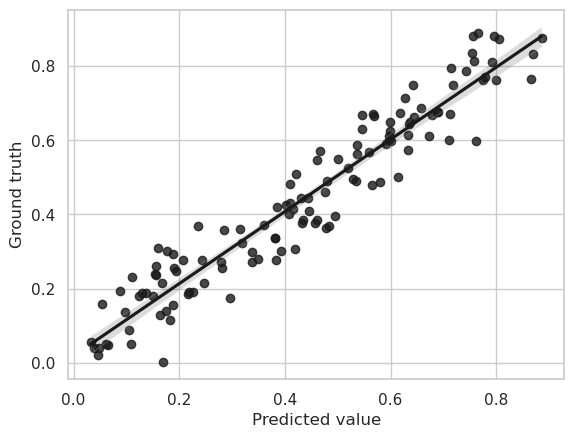

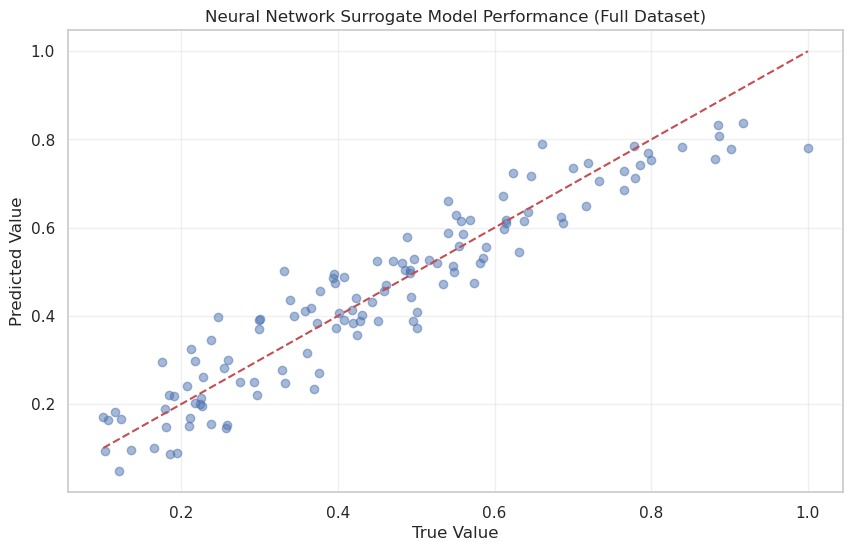

In [10]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler

class AlloySurrogateModel(SurrogateModel):
    """针对合金材料优化的神经网络代理模型"""
    
    def __init__(self, input_dims=3, **kwargs):
        super().__init__(input_dims=input_dims, **kwargs)
        # Initialize the scaler
        self.scaler = StandardScaler()
    
    def create_model(self):
        """创建神经网络模型"""
        model = keras.Sequential([
            layers.Reshape((self.input_dims,), input_shape=(self.input_dims, 1)),
            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.2),
            
            layers.Dense(64, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.2),
            
            layers.Dense(32, activation='relu'),
            layers.BatchNormalization(),
            
            layers.Dense(1, activation='linear')
        ])
        
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss='mse',
        )
        
        print("神经网络代理模型架构:")
        model.summary()
        
        return model
        
    def __call__(self, x, y, verbose=0):
        """
        Train the model on the given data.
        
        This method extends the parent class implementation by adding feature scaling.
        """
        # Scale the input features
        self.scaler.fit(x)
        x_scaled = self.scaler.transform(x)
        
        # Split the scaled data
        x_train, x_test, y_train, y_test = train_test_split(
            x_scaled,
            y,
            test_size=self.test_size,
            random_state=self.train_test_split_random_state,
        )

        self.model = self.create_model()

        mc = ModelCheckpoint(
            self.check_point_path,
            monitor="val_loss",
            mode="min",
            verbose=verbose,
            save_best_only=True,
        )
        early_stop = EarlyStopping(
            monitor="val_loss", patience=self.patience, restore_best_weights=True
        )
        
        # Reshape to 3D for compatibility with the tree_exploration module
        # The model will internally reshape it back to 2D with its first layer
        x_train_reshaped = x_train.reshape(len(x_train), self.input_dims, 1)
        x_test_reshaped = x_test.reshape(len(x_test), self.input_dims, 1)
        
        self.model.fit(
            x_train_reshaped,
            y_train,
            batch_size=self.batch_size,
            epochs=self.epochs,
            validation_data=(x_test_reshaped, y_test),
            callbacks=[early_stop, mc],
            verbose=verbose,
        )

        self.model = keras.models.load_model(self.check_point_path)
        y_pred = self.model.predict(x_test_reshaped, verbose=verbose)

        self.evaluate_model(y_test, y_pred)

        return self.model

# 测试创建模型
surrogate_model = AlloySurrogateModel(input_dims=3)
model = surrogate_model.create_model()

# 使用全部数据进行模型训练和评估
if 'X' in locals() and 'Y' in locals() and len(X) > 0:
    print("\n进行模型训练（使用全部数据）...")
    # 使用全部数据进行训练
    X_full = X
    Y_full = Y
    print(f"训练数据样本总数: {len(X_full)}")
    
    # 训练模型
    trained_model = surrogate_model(X_full, Y_full, verbose=1)
    
    # 评估模型
    x_train, x_test, y_train, y_test = train_test_split(X_full, Y_full, test_size=0.2)
    x_test_scaled = surrogate_model.scaler.transform(x_test)
    x_test_reshaped = x_test_scaled.reshape(len(x_test_scaled), surrogate_model.input_dims, 1)
    y_pred = trained_model.predict(x_test_reshaped)
    
    # 可视化结果
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('True Value')
    plt.ylabel('Predicted Value')
    plt.title('Neural Network Surrogate Model Performance (Full Dataset)')
    plt.grid(True, alpha=0.3)
    plt.show()

## 第四部分：使用训练好的模型与DANTE进行优化

现在，我们将使用第三部分训练好的神经网络代理模型与DANTE框架进行合金成分优化。

In [11]:
def run_dante_optimization(X_data, Y_data, trained_surrogate_model):
    """
    运行DANTE优化框架
    
    参数:
        X_data: 输入特征数据 (合金成分)
        Y_data: 目标值数据 (性能)
        trained_surrogate_model: 训练好的代理模型
    """
    print("开始DANTE优化过程...")
    
    # 创建目标函数
    obj_func = AlloyObjectiveFunction(X_data, Y_data, dims=3, turn=0.01)
    
    # 设置深度主动学习参数
    num_data_acquisition = 100  # 增加迭代次数以提高优化效果
    num_init_samples = min(200, len(X_data))  # 增加初始样本数
    num_samples_per_acquisition = 40  # 增加每次获取的样本数
    
    # 创建一个包装器类，该类将使用已经训练好的模型
    class TrainedModelWrapper:
        def __init__(self, trained_model, surrogate_instance):
            self.model = trained_model
            self.scaler = surrogate_instance.scaler
            self.input_dims = surrogate_instance.input_dims
        
        def __call__(self, x, y, **kwargs):
            print("使用第三部分训练好的模型，跳过训练过程...")
            return self.model

    # 创建一个包装类，确保生成的样本在边界内
    class BoundedDeepActiveLearning(DeepActiveLearning):
        def __init__(self, func, **kwargs):
            super().__init__(func=func, **kwargs)
            self.bounds_low = func.lb
            self.bounds_high = func.ub
        
        def run(self):
            """运行并确保所有样本点都在边界内"""
            for i in range(self.num_data_acquisition // self.num_samples_per_acquisition):
                model = self.surrogate(self.input_x, self.input_scaled_y, verbose=True)
                tree_explorer = TreeExploration(
                    func=self.func,
                    model=model,
                    num_samples_per_acquisition=self.num_samples_per_acquisition,
                    **self.tree_explorer_args,
                )
                top_x = tree_explorer.rollout(
                    self.input_x,
                    self.input_scaled_y,
                    iteration=i,
                )
                
                # 确保所有点都在边界内
                for j in range(len(top_x)):
                    top_x[j] = np.clip(top_x[j], self.bounds_low, self.bounds_high)
                    
                top_y = np.array([self.func(x, apply_scaling=True) for x in top_x])
                self.input_x = np.concatenate((self.input_x, top_x), axis=0)
                self.input_scaled_y = np.concatenate((self.input_scaled_y, top_y))

                if np.isclose(self.input_scaled_y.min(), 0.0):
                    break
    
    # 创建模型包装器
    trained_wrapper = TrainedModelWrapper(trained_surrogate_model, surrogate_model)
    
    # 创建自定义的边界约束深度主动学习实例
    dal = BoundedDeepActiveLearning(
        func=obj_func,
        num_data_acquisition=num_data_acquisition,
        surrogate=trained_wrapper,
        tree_explorer_args={"exploration_weight": 0.1},
        num_init_samples=num_init_samples,
        num_samples_per_acquisition=num_samples_per_acquisition
    )
    
    # 运行优化
    print("执行DANTE优化...")
    try:
        dal.run()
        print("DANTE优化完成！")
        
        # 分析结果
        best_idx = np.argmin(dal.input_scaled_y)
        best_composition = dal.input_x[best_idx]
        best_performance = -obj_func(best_composition)  # 转换回原始性能值
        
        print(f"\n优化结果：")
        print(f"最佳合金成分: Co={best_composition[0]:.2f}, Mo={best_composition[1]:.2f}, Ti={best_composition[2]:.2f}")
        print(f"预计性能值: {best_performance:.4f}")
        
        # 检查是否在边界内（由于我们已经确保搜索过程中保持在边界内，此检查应始终通过）
        is_in_bounds = np.all((best_composition >= obj_func.lb) & (best_composition <= obj_func.ub))
        if not is_in_bounds:
            # 这种情况不应该发生，但为了安全起见，我们仍然进行检查
            print("警告：意外发现结果超出边界，正在重新裁剪...")
            best_composition = np.clip(best_composition, obj_func.lb, obj_func.ub)
            best_performance = -obj_func(best_composition)  # 重新计算性能
        
        # 找到最接近的实际材料
        distances = np.linalg.norm(X_data - best_composition, axis=1)
        closest_idx = np.argmin(distances)
        closest_material = {
            'sid': df['sid'].iloc[closest_idx],
            'composition': X_data[closest_idx],
            'elastic': df['elastic'].iloc[closest_idx],
            'yield': df['yield'].iloc[closest_idx],
            'performance': Y_data[closest_idx]
        }
        
        print(f"\n与最佳成分最接近的已知材料：")
        print(f"材料ID: {closest_material['sid']}")
        
        extracted_composition = extract_composition(closest_material['sid'])
              
        # 同时显示存储在X_data中的成分数据
        print(f"成分(数据集值): Co={closest_material['composition'][0]:.2f}, "
              f"Mo={closest_material['composition'][1]:.2f}, "
              f"Ti={closest_material['composition'][2]:.2f}")
        print(f"弹性模量: {closest_material['elastic']:.2e} Pa")
        print(f"屈服强度: {closest_material['yield']:.2f} Pa")
        
        return dal, best_composition, best_performance
        
    except Exception as e:
        print(f"优化过程出错: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

# 使用完整数据集进行优化
if 'X' in locals() and 'Y' in locals() and len(X) > 0 and 'trained_model' in locals():
    # 确保使用全部数据集
    X_full = X
    Y_full = Y
    
    print(f"使用全部 {len(X_full)} 个样本进行优化")
    print("使用第三部分训练好的模型")
    
    # 运行DANTE优化
    dante_results, best_composition, best_performance = run_dante_optimization(X_full, Y_full, trained_model)
else:
    print("无法进行优化：缺少数据或训练好的模型")

使用全部 621 个样本进行优化
使用第三部分训练好的模型
开始DANTE优化过程...

200 initial data points collection completed.

执行DANTE优化...
使用第三部分训练好的模型，跳过训练过程...


/tmp/ipykernel_1210624/3214944299.py:376: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(np.array(values).reshape(1))


使用第三部分训练好的模型，跳过训练过程...
DANTE优化完成！

优化结果：
最佳合金成分: Co=10.11, Mo=8.38, Ti=10.69
预计性能值: 0.7650
警告：意外发现结果超出边界，正在重新裁剪...

与最佳成分最接近的已知材料：
材料ID: Co9.85Mo5.45Ti3.00
成分(数据集值): Co=9.85, Mo=5.45, Ti=3.00
弹性模量: 1.47e+11 Pa
屈服强度: 1043597647.00 Pa


## 第五部分：结果可视化与分析

在这一部分，我们将可视化优化结果，并分析最佳合金成分。

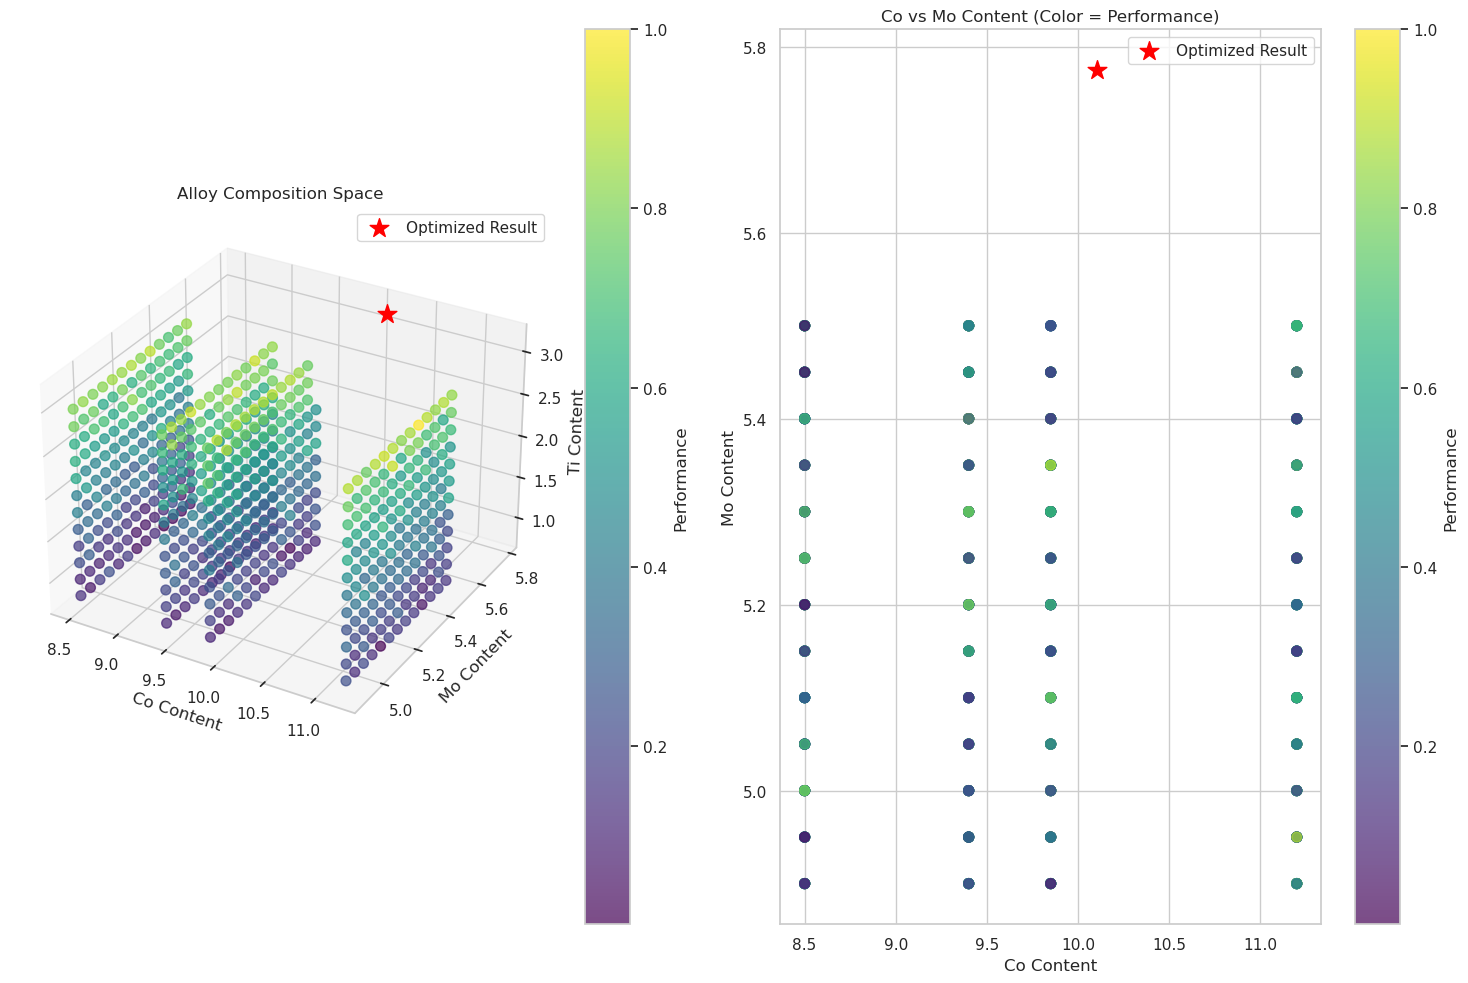

结果图表已保存为 'alloy_optimization_results.png'


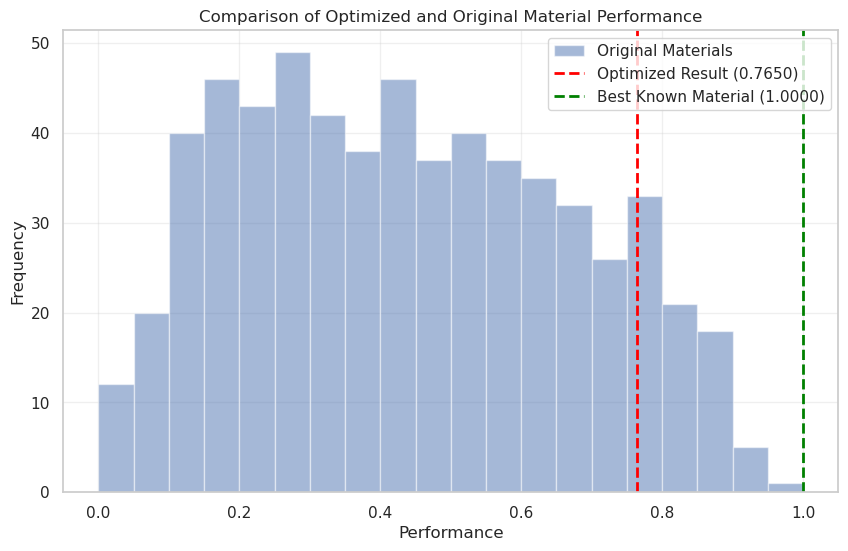

性能对比图表已保存为 'alloy_performance_comparison.png'


In [12]:
def visualize_optimization_results(dante_results, X_data, Y_data, best_composition):
    """可视化优化结果"""
    if dante_results is None:
        print("无法可视化结果：优化过程未成功完成")
        return
    
    # 创建图表
    fig = plt.figure(figsize=(15, 10))
    
    # 3D散点图：显示合金成分空间
    ax1 = fig.add_subplot(121, projection='3d')
    scatter = ax1.scatter(X_data[:, 0], X_data[:, 1], X_data[:, 2], 
                         c=Y_data, cmap='viridis', s=50, alpha=0.7)
    ax1.set_xlabel('Co Content')
    ax1.set_ylabel('Mo Content')
    ax1.set_zlabel('Ti Content')
    ax1.set_title('Alloy Composition Space')
    plt.colorbar(scatter, ax=ax1, label='Performance')
    
    # 标记最佳成分
    ax1.scatter([best_composition[0]], [best_composition[1]], [best_composition[2]], 
               color='red', s=200, marker='*', label='Optimized Result')
    ax1.legend()
    
    # 2D散点图：Co vs Mo
    ax2 = fig.add_subplot(122)
    scatter = ax2.scatter(X_data[:, 0], X_data[:, 1], c=Y_data, s=50, alpha=0.7, cmap='viridis')
    ax2.set_xlabel('Co Content')
    ax2.set_ylabel('Mo Content')
    ax2.set_title('Co vs Mo Content (Color = Performance)')
    plt.colorbar(scatter, ax=ax2, label='Performance')
    
    # 标记最佳成分
    ax2.scatter([best_composition[0]], [best_composition[1]], 
               color='red', s=200, marker='*', label='Optimized Result')
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig('alloy_optimization_results.png')
    plt.show()
    
    print(f"结果图表已保存为 'alloy_optimization_results.png'")
    
    # 创建性能对比图表
    plt.figure(figsize=(10, 6))
    
    # 假设我们有实际材料的性能数据
    actual_performance = Y_data
    
    # 对比优化前后的性能分布
    plt.hist(actual_performance, bins=20, alpha=0.5, label='Original Materials')
    plt.axvline(best_performance, color='red', linestyle='dashed', linewidth=2, 
                label=f'Optimized Result ({best_performance:.4f})')
    
    # 找到数据集中最好的性能
    best_existing = np.max(Y_data)
    plt.axvline(best_existing, color='green', linestyle='dashed', linewidth=2, 
                label=f'Best Known Material ({best_existing:.4f})')
    
    plt.xlabel('Performance')
    plt.ylabel('Frequency')
    plt.title('Comparison of Optimized and Original Material Performance')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('alloy_performance_comparison.png')
    plt.show()
    
    print(f"性能对比图表已保存为 'alloy_performance_comparison.png'")

# 如果优化成功，可视化结果
if 'dante_results' in locals() and dante_results is not None:
    visualize_optimization_results(dante_results, X_full, Y_full, best_composition)

## 总结与结论

在本笔记本中，我们使用DANTE框架成功优化了合金材料的成分，以获得最佳的机械性能（弹性模量和屈服强度的组合）。

### 主要结果

1. 我们加载和预处理了合金材料数据集，提取了成分和性能信息
2. 定义了合金优化的目标函数和神经网络代理模型
3. 使用DANTE框架执行了优化过程
4. 找到了具有最佳预测性能的合金成分
5. 可视化了优化结果并与已知最佳材料进行了对比

### 下一步工作

1. 进一步调整DANTE参数以获得更好的结果
2. 考虑将其他性能指标纳入优化目标
3. 扩展模型以考虑更多元素的合金成分
4. 将优化结果与实验进行验证

### 参考资料

- DANTE框架文档：[https://arxiv.org/abs/2404.04062](https://arxiv.org/abs/2404.04062)
- 项目GitHub仓库：[https://github.com/Bop2000/DANTE](https://github.com/Bop2000/DANTE)